**Importing Required Libraries**

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from xgboost import  XGBRegressor
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

**Reading data**

In [31]:
item_category=pd.read_csv('../input/competitive-data-science-predict-future-sales/item_categories.csv')
items=pd.read_csv('../input/competitive-data-science-predict-future-sales/items.csv')
shops=pd.read_csv('../input/competitive-data-science-predict-future-sales/shops.csv')
sales_train=pd.read_csv('../input/competitive-data-science-predict-future-sales/sales_train.csv')
test=pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv')

In [32]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


### The above dataset has 2935849 rows with 6 columns
<br>date_block_num is number given to each month 
<br>for example date_block_number =0 represents January 2013
    <br>        date_block_number =1 represents February 2013
        <br>    date_block_number =33 represents October 2015
        <br>item_price is the price of the item on that day
            <br>    item_cnt_day represents no of products sold on that day

In [33]:
sales_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


**Minimum value of item_price and item_cnt_day is negative. May be item_price and item_cnt_value is incorrect for few samples which are to be corrected.**

**Visualize number of items sold in each shop**

In [34]:
# no of items in each shop
t=sales_train[['shop_id','item_id']]
t2=t.groupby(['shop_id']).count().reset_index().rename(columns={"item_id":"item_count"})
t2.head()

,shop_id,item_count
0,0,9857
1,1,5678
2,2,25991
3,3,25532
4,4,38242


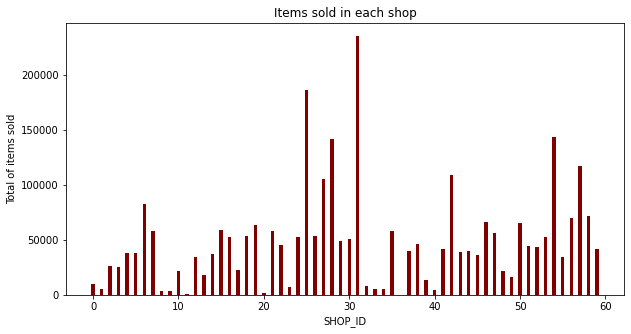

In [35]:
 
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(t2['shop_id'], t2['item_count'], color ='maroon',width = 0.4)
 
plt.xlabel("SHOP_ID")
plt.ylabel("Total of items sold")
plt.title("Items sold in each shop")
plt.show()

**It is clear from the above plot that items in shop_31 have registered more sales.**

**Visualize number of items sold of each category**

In [36]:
t3=pd.merge(sales_train,items,on=['item_id']).drop(['item_name','date','date_block_num','shop_id','item_price','item_cnt_day'],axis=1)
t3=t3.groupby(['item_category_id']).count().reset_index().rename(columns={"item_id":"item_count"})
t3.head()

,item_category_id,item_count
0,0,3
1,1,2
2,2,18461
3,3,25283
4,4,2304


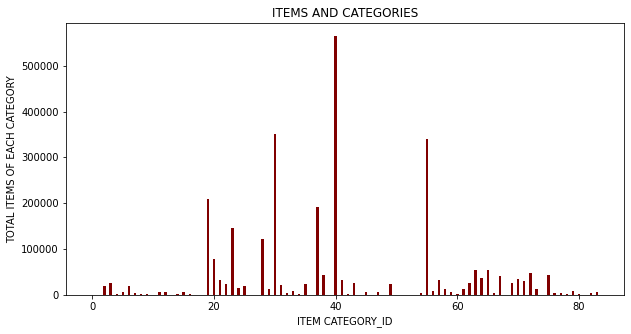

In [37]:
fig = plt.figure(figsize = (10, 5))
plt.bar(t3['item_category_id'], t3['item_count'], color ='maroon',width = 0.4)
plt.xlabel("ITEM CATEGORY_ID")
plt.ylabel("TOTAL ITEMS OF EACH CATEGORY")
plt.title("ITEMS AND CATEGORIES")
plt.show()

**Most of the categories have uniform sales and category_40 has registered more sales**

**Visualize number of items sold in each month**

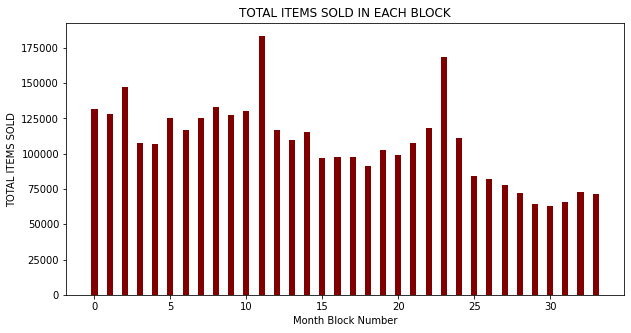

In [38]:
temp=sales_train.groupby(['date_block_num','shop_id','item_id']).item_cnt_day.sum()
temp=temp.reset_index(name = 'item_count_month')
temp1=temp.groupby(['date_block_num']).item_count_month.sum().reset_index(name = 'total_products')
fig = plt.figure(figsize = (10, 5))
plt.bar(temp1['date_block_num'], temp1['total_products'], color ='maroon',width = 0.4)
plt.xlabel("Month Block Number")
plt.ylabel("TOTAL ITEMS SOLD")
plt.title("TOTAL ITEMS SOLD IN EACH BLOCK")
plt.show()

**From the above plot it is clear that sales are following downward trend and two months, block_num(11) i.e. DEC-2013 and block_num(24) i.e. DEC-2014 have registered more sales**

In [39]:
sales_train.isna().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

**It is clear from above result that there are no missing values in sales_train dataset**

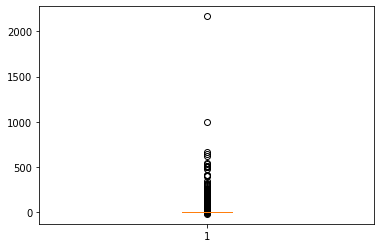

In [40]:
plt.boxplot(sales_train['item_cnt_day'])
plt.show()

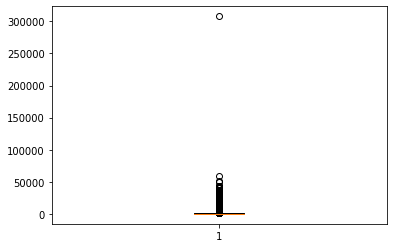

In [41]:
plt.boxplot(sales_train['item_price'])
plt.show()

**The above two plots can be used for setting thresholds to deal with outliers**

**Function for data preprocessing and final predictions**

In [42]:
def preprocess_predict(sales_train,item_category,items,shops,test):
    """ This function is used for data preprocessing
         model training  and making predictions
    """
    
    # Some of the shops are duplicate
    sales_train.loc[sales_train.shop_id == 0, 'shop_id'] = 57
    sales_train.loc[sales_train.shop_id == 1, 'shop_id'] = 58
    sales_train.loc[sales_train.shop_id == 10, 'shop_id'] = 11
    
    test.loc[test.shop_id == 0, 'shop_id'] = 57
    test.loc[test.shop_id == 1, 'shop_id'] = 58
    test.loc[test.shop_id == 10, 'shop_id'] = 11
    
    
    # selecting rows for which item_cnt_day > 0 and less than 1001
    sales_train=sales_train[sales_train['item_cnt_day']<1001]
    sales_train=sales_train[sales_train['item_cnt_day']>0]
    
    # selecting rows for which item_price > 0 and less than 100k
    
    sales_train=sales_train[sales_train['item_price']>0]
    sales_train=sales_train[sales_train['item_price']<100000]
    
    # Finding count of items sold in each month for every shop,item pair
    
    new_sales=sales_train.groupby(['date_block_num','item_id','shop_id']).item_cnt_day.sum().reset_index(name='item_count_month')
    
    # Create list for every month sales i.e. list[0] represents (item,shop) sold in b0 month
    lst=[]
    for i in range(34):
        s1=new_sales.loc[new_sales['date_block_num'] == i].drop(['date_block_num'],axis=1)
        col='b'+str(i)
        s1.rename(columns = {'item_count_month':col}, inplace = True)
        lst.append(s1)
        
    # merging all the lists to get (item,shop) pairs sold in all months
    
    for i in range(len(lst)):
        if i==0:
            data=lst[i]
            continue
        else:
            data=pd.merge(data,lst[i],on=['item_id','shop_id'],how='outer')
    
    # replacing NaN with 0
    data.fillna(0,inplace = True)
    
    # Every shop name starts with city name, extract city name and add it as a feature
    
    shop_names=shops['shop_name'].values
    city=[]
    for n in shop_names:
        city.append(n.split(' ')[0])
    shops['city']=city
    shops['city'] = shops['city'] .astype('category')
    shops['city'] = shops['city'] .cat.codes
    temp_shops=shops.drop('shop_name',axis=1)
    data=pd.merge(data,temp_shops,on=['shop_id'],how='left')
    
    # Creating mean_price of an item as a feature
    
    price=sales_train.groupby(['item_id','shop_id']).item_price.mean().reset_index(name='mean_price')
    data=pd.merge(data,price,on=['shop_id','item_id'],how='left')
    
    # Creating item_category_id feature
    
    temp_item=items.drop('item_name',axis=1)
    data=pd.merge(data,temp_item,on=['item_id'],how='left')
    
    # Creating Revenue feature. Here revenue is total revenue generated for item,shop pair in all 34 months
    # Revenue = item_count in all months * mean_price
    revenue=[]
    for index,row in tqdm(data.iterrows()):
        revenue.append(sum((row[2:37])*row['mean_price']))
    data['Revenue']=revenue
    
    # Clipping all sales_count values in the range of 0,20
    
    data2=data.iloc[:,2:36].clip(0,20)
    data.iloc[:,2:36]=data2
    
    # Merging test data with our preprocessed data
    
    test1=pd.merge(test,data,on=['shop_id','item_id'],how='left')
    test1.fillna(0,inplace=True)
    
    # Creating lag features with respect to b33
    
    test1['lag_1'] = test1['b33'].shift(1).clip(0,20)
    test1['lag_2'] = test1['b33'].shift(2).clip(0,20)
    test1['lag_3'] = test1['b33'].shift(3).clip(0,20)
    test1['lag_4'] = test1['b33'].shift(4).clip(0,20)
    test1['lag_5'] = test1['b33'].shift(5).clip(0,20)
    test1['lag_12'] = test1['b33'].shift(12).clip(0,20)
    test1.fillna(0,inplace=True)
    test1.to_csv('preprocessed_data.csv',index=False)
    
    # Dropping first five months, item_id,shop_id,ID and b33 will be used as target feature 
    
    X=test1.drop(['b33','ID','shop_id','item_id','b0','b1','b2','b3','b4','b5'],axis=1)
    y=test1['b33']
    
    # Splitting data into training and validation data sets
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Training XGBOOST
    
    model=XGBRegressor(objective='reg:squarederror',colsample_bytree=1, learning_rate=0.05, max_depth=5, n_estimators=500, subsample=1,min_child_weight=5)
    # Performance will be evaluated with RMSE and training will be stopped if improvement is not seen for 10 rounds
    
    model.fit(X_train,y_train, eval_set=[(X_train, y_train),(X_val, y_val)], verbose=False, early_stopping_rounds = 10)
    
    # Preparing test data for predictions
    
    test2=test1.drop(['ID','shop_id','item_id','b6','b0','b1','b2','b3','b4','b5'],axis=1)
    
    res=model.predict(test2)
    
    # clipping all the predicted values in the range 0,20
    
    res=res.clip(0,20)
    res1=[]
    for i in range(len(res)):
        res1.append(res[i])
    test['item_cnt_month']=res1
    
    test=test.drop(['shop_id','item_id'],axis=1)
    pickle.dump(model, open("xgb.dat", "wb"))
    
   
    return test,model,X_val,y_val

In [46]:
def evaluate_model(model,X_val,y_val,predictions,sales):
    
    """
    This function is used for evaluating the performance of model 
    by visualizing RMSE and also visualising feature importance of 
    XGBOOST
    """
     # Visvualising feature importance
    
    imp=model.feature_importances_
    features = X_val.columns
    indices = (np.argsort(imp))[-25:]
    plt.figure(figsize=(10,12))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), imp[indices], color='r', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    
    # plot RMSE

    results = model.evals_result()
    epochs = len(results['validation_0']['rmse'])
    x_axis = range(0, epochs)
    fig, ax = plt.subplots(figsize=(8,5))
    ax.plot(x_axis, results['validation_0']['rmse'], label='Training')
    ax.plot(x_axis, results['validation_1']['rmse'], label='Validation')
    ax.legend()
    plt.xlabel('Round Number')
    plt.ylabel('RMSE')
    plt.title('XGBoost RMSE')
    plt.show()
    
    # Visualize actual and predicted values of B33
    
    y_pred=model.predict(X_val).clip(0,20)
    x_ax = range(len(y_val))
    plt.plot(x_ax, y_val, label="original")
    plt.plot(x_ax, y_pred, label="predicted")
    plt.title("Actual and predicted data of B33")
    plt.legend()
    plt.show()
    
    #Total products that will be sold in b34 month as per predicted result
    
    b34=predictions['item_cnt_month'].sum()
    df = {'date_block_num': 34, 'total_products': b34}
    temp1 = sales.append(df, ignore_index = True)
    fig = plt.figure(figsize = (10, 5))
    plt.bar(sales['date_block_num'], sales['total_products'], color ='maroon',width = 0.4)
    plt.xlabel("Month Block Number")
    plt.ylabel("TOTAL ITEMS SOLD")
    plt.title("TOTAL ITEMS SOLD IN EACH BLOCK & LAST BLOCK REPRESENTS PREDICTED SALES OF NEXT MONTH")
    plt.show()

In [44]:
submission,model,X_val,y_val=preprocess_predict(sales_train,item_category,items,shops,test)


418882it [01:08, 6154.97it/s]


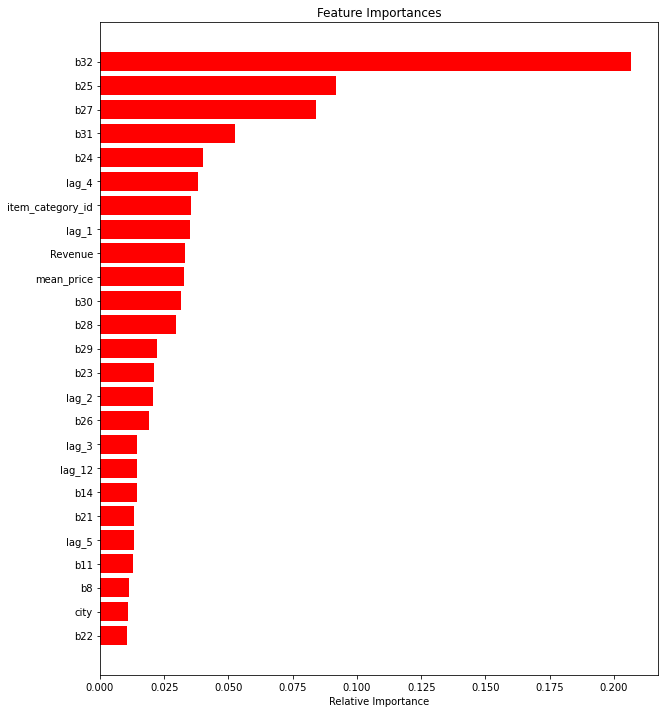

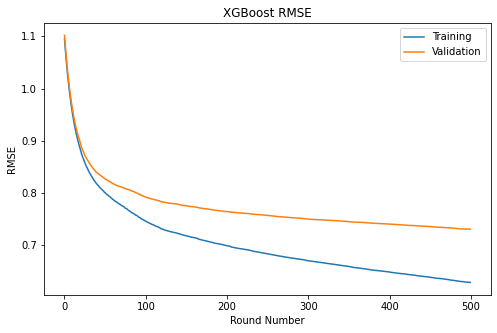

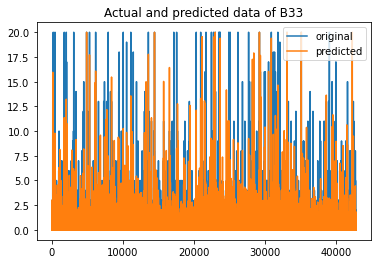

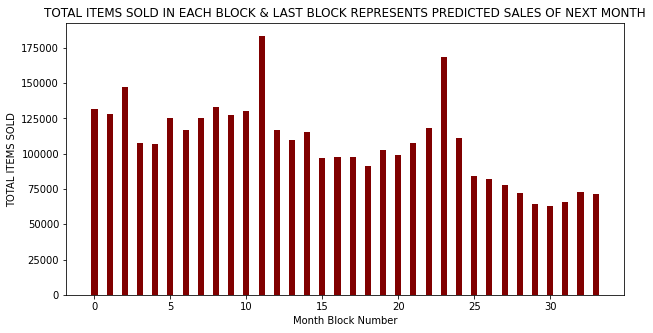

In [47]:
evaluate_model(model,X_val,y_val,submission,temp1)

**ERROR ANALYSIS**

1. One of the important point is 50% of the test data is new i.e. more than 1 lakh (item,shop) pairs that are in test data are not in train data. (These item,shop) pairs may be introduced new i.e. in B34.

2. When single point error analysis is performed it is found that the gap between predicted and actual value is more because either the (item,shop)pair is seen only in last month i.e. B33 or it is completely new. 